In [1]:
# ==============================================================================
# BÖLÜM 1: Gerekli Kütüphaneleri İçe Aktarma
# ==============================================================================
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import random

2025-09-26 16:50:11.405201: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758905411.649462      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758905411.715900      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [10]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# ==============================================================================
# BÖLÜM 2: Veri Hazırlığı ve Ön İşleme
# ==============================================================================
import os
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array

print("Veri hazırlığı başlatılıyor...")

# Veri setinin ana dizin yolu.
# Kaggle ortamında veri setlerinin yolu genellikle '/kaggle/input/' ile başlar.
base_dir = "/kaggle/input/breast-histopathology-images"

# Tüm görüntü yollarını ve etiketlerini depolamak için boş listeler
image_paths = []
labels = []

# Ana dizindeki tüm hasta klasörlerini döngü ile gez
for patient_folder in os.listdir(base_dir):
    # Hastanın tam yolunu oluştur
    patient_path = os.path.join(base_dir, patient_folder)
    
    # Sadece klasörleri işleme al (dosyaları atla)
    if not os.path.isdir(patient_path):
        continue
    
    # Her hasta klasöründeki "0" (benign) ve "1" (malignant) alt klasörlerini gez
    for label_folder in ["0", "1"]:
        # Etiket klasörünün tam yolunu oluştur
        folder_path = os.path.join(patient_path, label_folder)
        
        # Klasör varsa devam et
        if os.path.exists(folder_path):
            # Klasördeki tüm görüntü dosyalarını gez
            for img_file in os.listdir(folder_path):
                # Sadece .png uzantılı dosyaları al
                if img_file.endswith(".png"):
                    # Görüntü dosyasının tam yolunu image_paths listesine ekle
                    image_paths.append(os.path.join(folder_path, img_file))
                    # İlgili etiketi (0 veya 1) labels listesine ekle
                    labels.append(int(label_folder))

# Toplanan verileri kullanarak bir pandas DataFrame'i oluştur
data_df = pd.DataFrame({
    "image_path": image_paths,
    "label": labels
})

# DataFrame'in ilk 5 satırını ve toplam örnek sayısını yazdır
print("Toplam örnek sayısı:", len(data_df))
print(data_df.head())

# ---
# Veri Kümesini Dengeli Olarak Küçültme
# ---
print("Veri kümesi dengeli olarak örnekleniyor...")
# Her sınıftan (0 ve 1) 5000 adet örnek seçiyoruz.
samples_per_class = 5000 
df_0 = data_df[data_df['label'] == 0].sample(n=samples_per_class, random_state=42)
df_1 = data_df[data_df['label'] == 1].sample(n=samples_per_class, random_state=42)
# Örneklenmiş veri çerçevelerini birleştirip karıştırıyoruz.
data_df = pd.concat([df_0, df_1]).sample(frac=1, random_state=42).reset_index(drop=True)
print(f"Yeni dengeli örnek sayısı: {len(data_df)}")
print(data_df['label'].value_counts())


Veri hazırlığı başlatılıyor...
Toplam örnek sayısı: 277524
                                          image_path  label
0  /kaggle/input/breast-histopathology-images/102...      0
1  /kaggle/input/breast-histopathology-images/102...      0
2  /kaggle/input/breast-histopathology-images/102...      0
3  /kaggle/input/breast-histopathology-images/102...      0
4  /kaggle/input/breast-histopathology-images/102...      0
Veri kümesi dengeli olarak örnekleniyor...
Yeni dengeli örnek sayısı: 10000
label
1    5000
0    5000
Name: count, dtype: int64



Veri görselleştirme başlatılıyor...


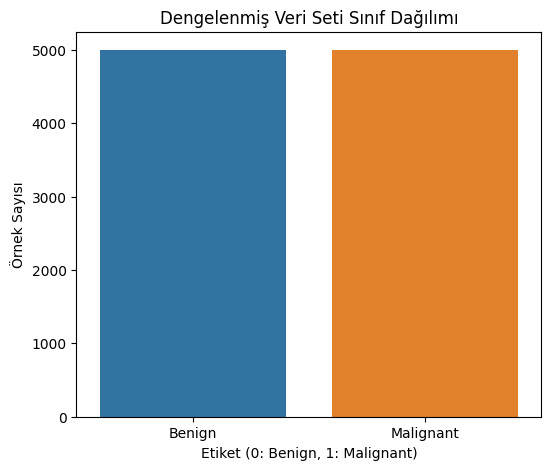

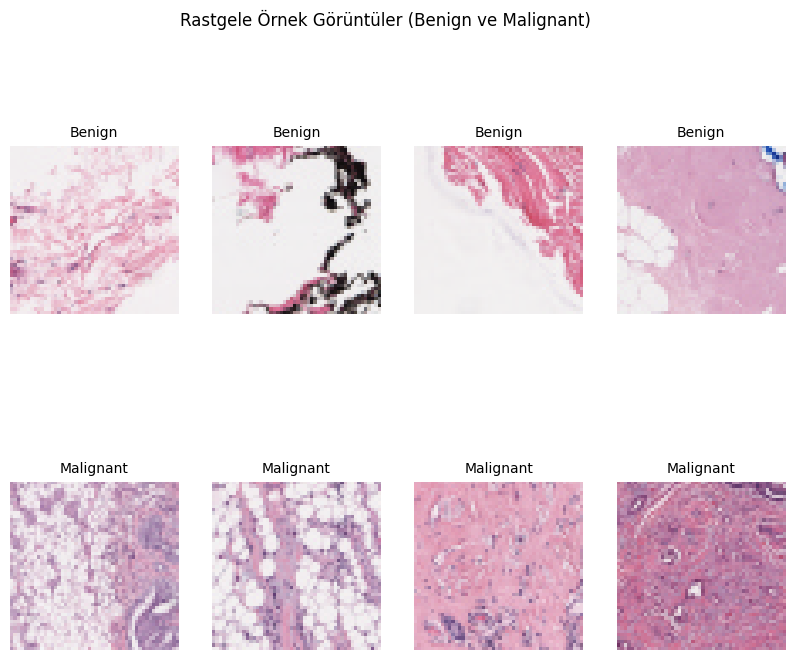

X shape: (10000, 128, 128, 3)
y shape: (10000,)
Train set: (8000, 128, 128, 3) (8000,)
Test set: (2000, 128, 128, 3) (2000,)
Veri hazırlığı tamamlandı.


In [3]:
# ==============================================================================
# BÖLÜM 2.1: Veri Görselleştirmeleri (EKLENDİ)
# Bu bölümde veri seti hakkında görsel istatistikler sunulur.
# ==============================================================================
print("\nVeri görselleştirme başlatılıyor...")

# Dengelenmiş veri setindeki sınıf dağılımını görselleştir
plt.figure(figsize=(6, 5))
sns.countplot(x='label', data=data_df)
plt.title('Dengelenmiş Veri Seti Sınıf Dağılımı')
plt.xlabel('Etiket (0: Benign, 1: Malignant)')
plt.ylabel('Örnek Sayısı')
plt.xticks([0, 1], ['Benign', 'Malignant'])
plt.show()

# Her sınıftan rastgele birkaç örnek görselleştir
plt.figure(figsize=(10, 8))
benign_samples = data_df[data_df['label'] == 0].sample(4, random_state=42)
malignant_samples = data_df[data_df['label'] == 1].sample(4, random_state=42)
sample_df = pd.concat([benign_samples, malignant_samples])

for i, (idx, row) in enumerate(sample_df.iterrows()):
    plt.subplot(2, 4, i + 1)
    img = load_img(row['image_path'])
    plt.imshow(img)
    plt.title(f"{'Malignant' if row['label'] == 1 else 'Benign'}", fontsize=10)
    plt.axis('off')
plt.suptitle('Rastgele Örnek Görüntüler (Benign ve Malignant)')
plt.show()


# ---
# Görüntü Yükleme ve Ön İşleme
# ---

# Görüntüleri yüklemek ve ön işlemek için sabit boyut tanımla
IMG_SIZE = (128, 128)

# Görüntüleri ve etiketleri depolamak için NumPy dizileri
X = []  # Görüntüler
y = []  # Etiketler

# Örneklenmiş DataFrame'deki tüm görüntüler üzerinde döngü yaparak yükleme ve ön işleme yap
for _, row in data_df.iterrows():
    try:
        # Görüntüyü belirtilen boyuta yeniden boyutlandırarak yükle
        img = load_img(row['image_path'], target_size=IMG_SIZE)
        # Görüntüyü bir NumPy dizisine dönüştür ve 0-1 arasına normalleştir
        img_array = img_to_array(img) / 255.0
        # İşlenmiş görüntüyü X listesine ekle
        X.append(img_array)
        # Etiketi y listesine ekle
        y.append(row['label'])
    except Exception as e:
        print(f"Hata oluştu: {row['image_path']}, Hata: {e}")

# Python listelerini NumPy dizilerine dönüştür
X = np.array(X)
y = np.array(y)

print("X shape:", X.shape)
print("y shape:", y.shape)

# ---
# Veri Setini Ayırma
# ---

# Veriyi eğitim ve test kümelerine ayır
# test_size=0.2 (verinin %20'si test için ayrılır)
# stratify=y (etiket dağılımını eğitim ve test kümelerinde aynı tutar)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Train set:", X_train.shape, y_train.shape)
print("Test set:", X_test.shape, y_test.shape)
print("Veri hazırlığı tamamlandı.")

In [4]:
# ==============================================================================
# BÖLÜM 3: Model Tanımlama ve Eğitme
# ==============================================================================
print("\nModel oluşturuluyor...")
model = Sequential([
    # İlk evrişim katmanı: 32 filtre, 3x3 kernel, relu aktivasyonu. Giriş boyutu 128x128x3.
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    # Maksimum havuzlama katmanı: 2x2 pencere ile boyutu küçültür
    MaxPooling2D((2,2)),
    
    # İkinci evrişim katmanı: 64 filtre
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    
    # Üçüncü evrişim katmanı: 128 filtre
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    
    # Görsel veriyi 1D vektöre dönüştür
    Flatten(),
    
    # Tam bağlantılı gizli katman: 128 nöron, relu aktivasyonu
    Dense(128, activation='relu'),
    # Dropout katmanı: Aşırı uydurmayı (overfitting) önlemek için nöronların %50'sini rastgele kapatır
    Dropout(0.5),
    
    # Çıkış katmanı: 1 nöron (binary classification için)
    # sigmoid aktivasyonu, çıktıyı 0-1 arasına sıkıştırır
    Dense(1, activation='sigmoid')
])

# Modeli derle
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Model özetini göster
model.summary()

# Eğitim verisi için veri artırma (Data Augmentation)
# Bu teknik, modelin genelleme yeteneğini artırarak aşırı uydurmayı önler.
train_datagen = ImageDataGenerator(
    rotation_range=20,      # Rastgele döndürme
    width_shift_range=0.1,  # Yatay kaydırma
    height_shift_range=0.1, # Dikey kaydırma
    zoom_range=0.1,         # Rastgele yakınlaştırma
    horizontal_flip=True,   # Yatay çevirme
    vertical_flip=True      # Dikey çevirme
)

# Eğitim verisini ImageDataGenerator ile akışa al
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)

print("\nModel eğitimi başlatılıyor...")
# Modeli artırılmış veri ile eğit
history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train)//32, # Her adımda kaç batch işleneceği
    epochs=10,                      # Eğitim döngüsü sayısı
    validation_data=(X_test, y_test)  # Doğrulama verisi
)

# Modeli kaydet
model.save("breast_cancer_cnn_model.keras")
print("\nModel başarıyla kaydedildi: breast_cancer_cnn_model.keras")


Model oluşturuluyor...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-09-26 16:52:13.344690: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)


Model eğitimi başlatılıyor...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 126s 492ms/step - accuracy: 0.6504 - loss: 0.6206 - val_accuracy: 0.8025 - val_loss: 0.4528
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 122s 489ms/step - accuracy: 0.7822 - loss: 0.4858 - val_accuracy: 0.8065 - val_loss: 0.4478
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 120s 478ms/step - accuracy: 0.7965 - loss: 0.4675 - val_accuracy: 0.8055 - val_loss: 0.4373
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 117s 469ms/step - accuracy: 0.8004 - loss: 0.4550 - val_accuracy: 0.8170 - val_loss: 0.4167
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 124s 495ms/step - accuracy: 0.8063 - loss: 0.4455 - val_accuracy: 0.8205 - val_loss: 0.4171
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 117s 468ms/step - accuracy: 0.8195 - loss: 0.4237 - val_accuracy: 0.8120 - val_loss: 0.4241
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 116s 464ms/step - accuracy: 0.8088 - loss: 0.4355 - val_accuracy: 0.8020 - val_loss: 0.4555
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 118s 472ms/step - accuracy: 0.8097 -


Model değerlendirme ve tahminler...


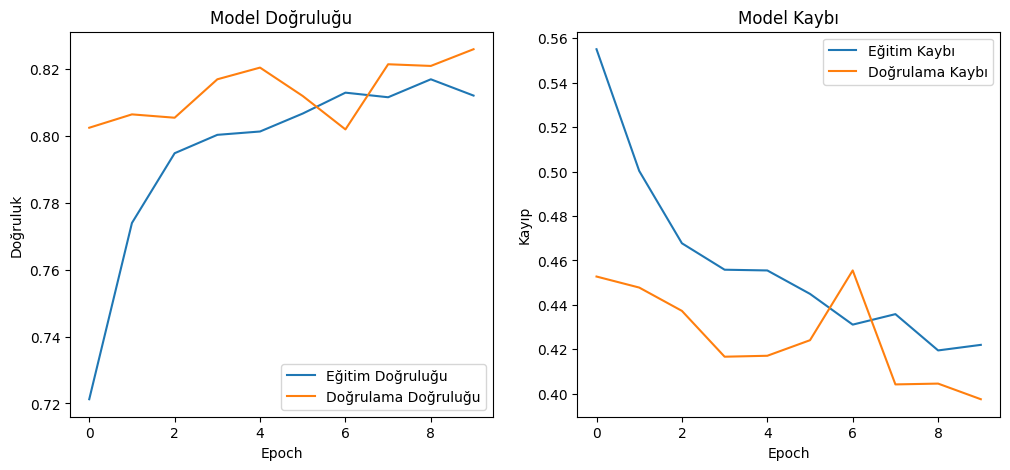

63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step
Sınıflandırma Raporu:

              precision    recall  f1-score   support

      Benign       0.81      0.85      0.83      1000
   Malignant       0.84      0.81      0.82      1000

    accuracy                           0.83      2000
   macro avg       0.83      0.83      0.83      2000
weighted avg       0.83      0.83      0.83      2000



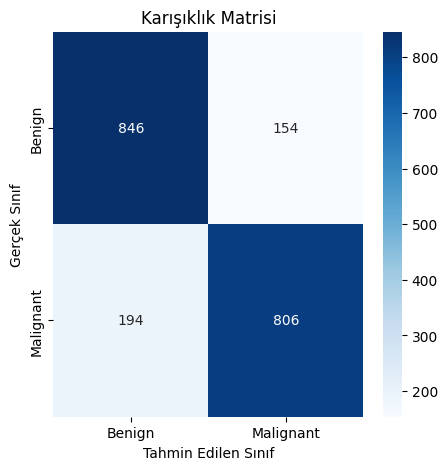

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


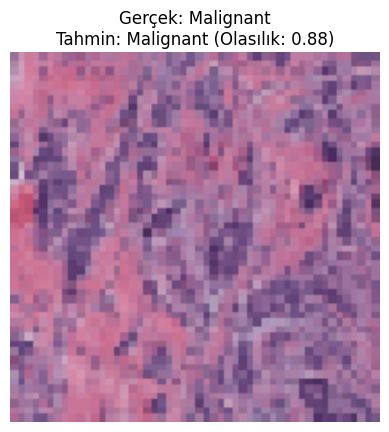

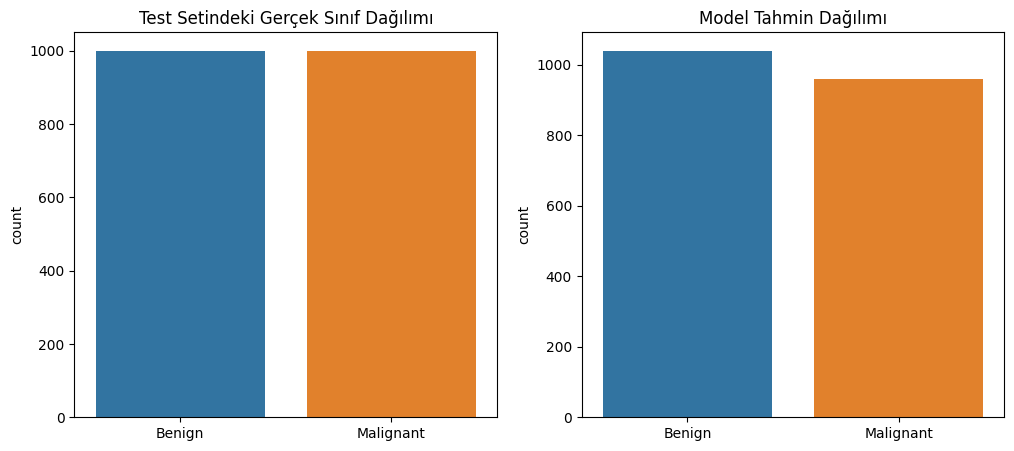

In [5]:
# ==============================================================================
# BÖLÜM 4: Model Değerlendirme ve Tahmin
# ==============================================================================
print("\nModel değerlendirme ve tahminler...")

# Modelin eğitim geçmişi (accuracy ve loss) grafiklerini çiz
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Model Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Model Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()
plt.show()

# --- Tahminleri al ve sınıflandır ---
# Model tüm test setini tahmin ediyor
y_pred_prob = model.predict(X_test)
# 0.5 eşik değeri ile sınıflara ayır
y_pred = (y_pred_prob > 0.5).astype(int)

# --- Sınıflandırma raporu ---
# precision, recall, f1-score gibi detaylı metrikleri içerir
report = classification_report(y_test, y_pred, target_names=["Benign","Malignant"])
print("Sınıflandırma Raporu:\n")
print(report)

# --- Confusion Matrix (Karışıklık Matrisi) ---
# Modelin hangi sınıfları doğru/yanlış tahmin ettiğini gösterir
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["Benign","Malignant"], 
            yticklabels=["Benign","Malignant"])
plt.xlabel("Tahmin Edilen Sınıf")
plt.ylabel("Gerçek Sınıf")
plt.title("Karışıklık Matrisi")
plt.show()


# --- Tek bir örnek üzerinde tahmin yapma ---
# Test setinden rastgele bir örnek seç
idx = random.randint(0, len(X_test) - 1)
sample_img = X_test[idx].reshape(1, 128, 128, 3)
true_label = y_test[idx]

# Tahmin yap
pred_prob = model.predict(sample_img)[0][0]
pred_label = 1 if pred_prob > 0.5 else 0

# Görseli ve tahmin sonuçlarını göster
plt.imshow(X_test[idx])
plt.axis("off")
plt.title(
    f"Gerçek: {'Benign' if true_label==0 else 'Malignant'}\n"
    f"Tahmin: {'Benign' if pred_label==0 else 'Malignant'} (Olasılık: {pred_prob:.2f})"
)
plt.show()

# --- Sınıf Dağılımlarını Karşılaştırma ---
# Gerçek etiketlerin ve model tahminlerinin dağılımını gösterir
plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
sns.countplot(x=y_test)
plt.xticks([0,1], ["Benign", "Malignant"])
plt.title("Test Setindeki Gerçek Sınıf Dağılımı")

plt.subplot(1,2,2)
sns.countplot(x=y_pred.flatten())
plt.xticks([0,1], ["Benign", "Malignant"])
plt.title("Model Tahmin Dağılımı")
plt.show()



BÖLÜM 5: İleri Düzey Değerlendirme ve İyileştirme Teknikleri başlatılıyor...

ROC Eğrisi ve AUC hesaplanıyor...


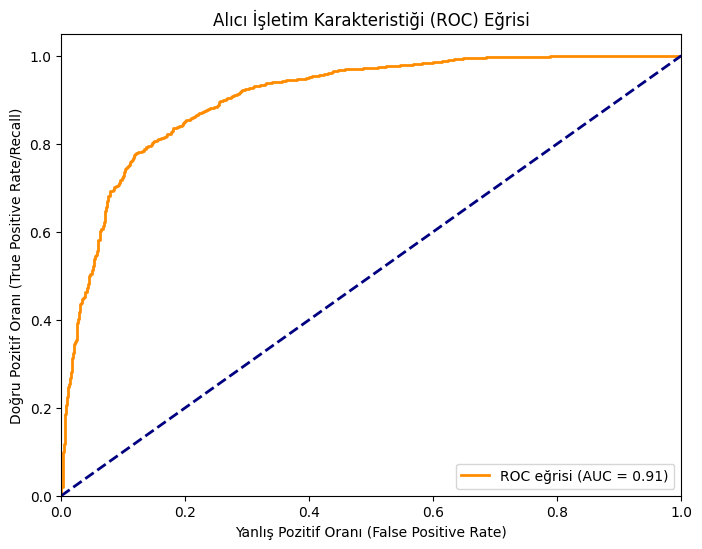

Test Seti AUC Değeri: 0.9053

Precision-Recall Eğrisi Analizi...


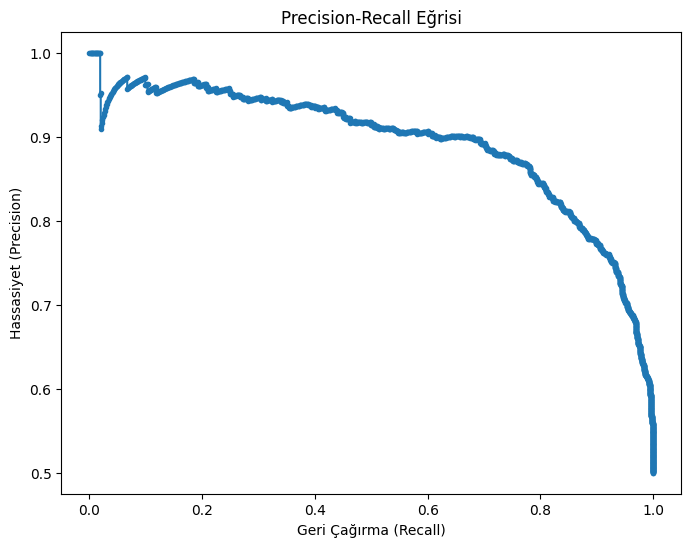

In [12]:
# ==============================================================================
# BÖLÜM 5: İleri Düzey Değerlendirme ve İyileştirme Teknikleri
# ==============================================================================
print("\nBÖLÜM 5: İleri Düzey Değerlendirme ve İyileştirme Teknikleri başlatılıyor...")

# --- 5.1: ROC Eğrisi ve AUC (Area Under the Curve) ---
# İkili sınıflandırma modellerinin performansını değerlendirmede kritik bir metrik.
from sklearn.metrics import roc_curve, auc

print("\nROC Eğrisi ve AUC hesaplanıyor...")

# Model tahmin olasılıkları y_pred_prob zaten hesaplanmıştı.
# fpr (False Positive Rate), tpr (True Positive Rate) ve eşik değerlerini hesapla
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
# Eğrinin altındaki alanı (Area Under the Curve) hesapla
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC eğrisi (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # Rastgele sınıflandırıcının çizgisi
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Yanlış Pozitif Oranı (False Positive Rate)')
plt.ylabel('Doğru Pozitif Oranı (True Positive Rate/Recall)')
plt.title('Alıcı İşletim Karakteristiği (ROC) Eğrisi')
plt.legend(loc="lower right")
plt.show()
print(f"Test Seti AUC Değeri: {roc_auc:.4f}")

# --- 5.2: Geri Çağırma (Recall) ve Hassasiyet (Precision) Eşik Değeri Analizi ---
# Farklı eşik değerlerinde Recall ve Precision metriklerinin nasıl değiştiğini görmek önemlidir.
from sklearn.metrics import precision_recall_curve

print("\nPrecision-Recall Eğrisi Analizi...")
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Geri Çağırma (Recall)')
plt.ylabel('Hassasiyet (Precision)')
plt.title('Precision-Recall Eğrisi')
plt.show()

# --- 5.3: Daha Kapsamlı Model Değerlendirme (K-Fold Çapraz Doğrulama) ---
# Modelin tek bir test/eğitim ayrımına olan bağımlılığını azaltmak için.
# Not: Tam bir K-Fold çalıştırmak uzun sürecektir. Sadece metodolojiyi göstermek için bir not bırakıyorum.

# print("\nK-Fold Çapraz Doğrulama Metodolojisi (Göstermek Amaçlı)")
# from sklearn.model_selection import StratifiedKFold
#
# kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# k_fold_accuracies = []
#
# # Her katlama (fold) için döngü
# for fold, (train_index, val_index) in enumerate(kf.split(X, y)):
#     X_train_fold, X_val_fold = X[train_index], X[val_index]
#     y_train_fold, y_val_fold = y[train_index], y[val_index]
#
#     # Yeni model oluştur, derle ve eğit (Burada modelinizin yapısını tekrarlayacaksınız)
#     # ...
#
#     # Model değerlendir
#     # loss, acc = model.evaluate(X_val_fold, y_val_fold, verbose=0)
#     # k_fold_accuracies.append(acc)
#
# # print(f"Ortalama K-Fold Doğruluğu: {np.mean(k_fold_accuracies):.4f}")


# --- 5.4: Grad-CAM ile Model Yorumlanabilirliği (Açıklanabilir Yapay Zeka - XAI) ---
# Modelin karar verirken görüntünün hangi bölgelerine odaklandığını görselleştirme.
# Bu, medikal görüntülerde modelin doğru yere baktığını doğrulamak için çok önemlidir.
# NOT: Grad-CAM uygulaması karmaşık olduğu için burada sadece bir örnek gösterilecektir.